# Preparing the data for the analysis

In [25]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np

xr.set_options(display_expand_attrs=False, display_expand_data=False)
np.set_printoptions(threshold=10, edgeitems=2)

In [26]:
# This cell stores the variables for the rest of the script, so it is easier to change if needed
data_file_path = '../../../results/final_test.nc'

First, we have to load the data that came as an output of the model. Variables of interest are stored in a netcdf file (.nc), that we will load as a dataset, and convert to a pandas dataframe. 

In [27]:
variables = ['define_tot_eq_define_total_impact',
       'dice_tot_eq_dice_total_impact', 'dsk_tot_eq_dsk_total_impact',
       'fund_tot_eq_monetary_impact', 'fund_tot_eq_total_deaths',
       'fund_tot_eq_fund_total_impact', 'fund_tot_total_damage',
       'witness_tot_eq_witness_total_impact', 'time',
       'temperature_change', 'total_population', 'extra_extra_exponent',
       'extra_extra_normalisation_constant', 'extra_extra_gdp_modifyer',
       'total_radiative_forcing', 
       'gross_domestic_product_nominal', 'population_35_regions', 
       'average_disposable_income_per_capita']

damage_variables = ['define_tot_eq_define_total_impact',
       'dice_tot_eq_dice_total_impact', 'dsk_tot_eq_dsk_total_impact',
       'fund_tot_eq_monetary_impact', 'fund_tot_total_damage',
       'fund_tot_eq_fund_total_impact', 'witness_tot_eq_witness_total_impact']      

ds = xr.open_dataset(data_file_path)
df = ds[variables].to_dataframe().reset_index()
df = df.rename(columns={'extra_extra_gdp_modifyer': 'coef'})


We now have a dataframe : 

In [28]:
ds

<xarray.Dataset> Size: 51MB
Dimensions:                                                                (
                                                                            A MATRIX YEARS I: 15,
                                                                            AEZ I: 4,
                                                                            AGE ADULTS I: 10,
                                                                            AGE CHAIN I: 16,
                                                                            AGE CHAIN MIDDLE I: 15,
                                                                            ...
                                                                            bottom: 1,
                                                                            lower: 3,
                                                                            pprofile: 4,
                                                                            upper: 3,
                                                                            Run: 50,
                                                                            time: 66)
Coordinates: (12/255)
  * A MATRIX YEARS I                                                       (A MATRIX YEARS I) <U8 480B ...
  * AEZ I                                                                  (AEZ I) <U13 208B ...
  * AGE ADULTS I                                                           (AGE ADULTS I) <U6 240B ...
  * AGE CHAIN I                                                            (AGE CHAIN I) <U7 448B ...
  * AGE CHAIN MIDDLE I                                                     (AGE CHAIN MIDDLE I) <U6 360B ...
  * AGE CHAIN YOUNG I                                                      (AGE CHAIN YOUNG I) <U6 360B ...
    ...                                                                     ...
  * bottom                                                                 (bottom) <U6 24B ...
  * lower                                                                  (lower) <U6 72B ...
  * pprofile                                                               (pprofile) <U9 144B ...
  * upper                                                                  (upper) <U6 72B ...
  * time                                                                   (time) float64 528B ...
  * Run                                                                    (Run) int32 200B ...
Data variables: (12/174)
    define_46_eq_damage_function                                           (Run, time) float64 26kB ...
    define_tot_eq_define_total_impact                                      (Run, time, region) float64 924kB ...
    dice_5_eq_damage_function                                              (Run, time) float64 26kB ...
    dice_tot_eq_dice_total_impact                                          (Run, time, region) float64 924kB ...
    dsk_tot_eq_dsk_total_impact                                            (Run, time, region) float64 924kB ...
    extra_extra_gdp_modifyer                                               (Run, time, region) float64 924kB ...
    ...                                                                     ...
    fund_w1_tau_parameter                                                  (Run) float64 400B ...
    fund_extra_initial_revenue                                             (Run, region) float64 14kB ...
    fund_extra_initial_gdp                                                 (Run, region) float64 14kB ...
    fund_extra_initial_population                                          (Run, region) float64 14kB ...
    switch_wiliam_amoc_change                                              (Run) float64 400B ...
    witness_epsilon                                                        (Run) float64 400B ...
Attributes: (5)

In [29]:
df

,Run,time,region,define_tot_eq_define_total_impact,dice_tot_eq_dice_total_impact,dsk_tot_eq_dsk_total_impact,fund_tot_eq_monetary_impact,fund_tot_eq_total_deaths,fund_tot_eq_fund_total_impact,fund_tot_total_damage,witness_tot_eq_witness_total_impact,temperature_change,total_population,extra_extra_exponent,extra_extra_normalisation_constant,coef,total_radiative_forcing,gross_domestic_product_nominal,population_35_regions,average_disposable_income_per_capita
0,0,2005.0,AUSTRIA,0.000000e+00,0.000000e+00,0.0,NaN,NaN,NaN,NaN,0.000000e+00,0.845000,6.541007e+09,0.582127,47277.739995,0.000000,1.714491,3.786850e+05,8.253656e+06,0.000000
1,0,2005.0,BELGIUM,6.443104e+02,7.783280e+02,0.0,1.379671e+09,5.746519e+06,1.379671e+09,4.973581e+06,1.315127e+03,0.845000,6.541007e+09,0.582127,47277.739995,0.686361,1.714491,4.580816e+05,1.054688e+07,24767.399895
2,0,2005.0,BULGARIA,2.501084e+01,3.021313e+01,0.0,2.799410e+08,5.009851e+01,2.799410e+08,8.615126e+05,5.105057e+01,0.845000,6.541007e+09,0.582127,47277.739995,0.247350,1.714491,4.934207e+04,7.686964e+06,4290.060541
3,0,2005.0,CROATIA,3.482407e+01,4.206754e+01,0.0,2.565073e+08,2.853332e+01,2.565073e+08,1.519235e+06,7.108075e+01,0.845000,6.541007e+09,0.582127,47277.739995,0.344144,1.714491,4.937873e+04,4.378066e+06,7565.730576
4,0,2005.0,CYPRUS,2.145202e+01,2.591408e+01,0.0,9.993271e+07,5.360278e+05,9.993271e+07,3.055627e+06,4.378653e+01,0.845000,6.541007e+09,0.582127,47277.739995,0.516904,1.714491,2.025158e+04,1.027657e+06,15217.411656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115495,49,2070.0,INDIA,8.718532e+06,1.442951e+06,0.0,1.490505e+10,2.596081e+04,1.490505e+10,2.578250e+05,3.082382e+06,3.332688,7.951395e+09,-0.385949,34549.432151,3.825357,6.299000,9.795721e+06,1.466325e+09,1068.387514
115496,49,2070.0,LATAM,3.970728e+06,6.571707e+05,0.0,2.734215e+10,5.597925e+03,2.734215e+10,1.918663e+06,1.403826e+06,3.332688,7.951395e+09,-0.385949,34549.432151,1.649069,6.299000,1.034895e+07,3.860440e+08,9453.049938
115497,49,2070.0,RUSSIA,5.849434e+06,9.681038e+05,0.0,3.434705e+10,4.179328e+02,3.434705e+10,4.321364e+07,2.068030e+06,3.332688,7.951395e+09,-0.385949,34549.432151,0.493690,6.299000,5.092421e+07,1.320865e+08,215132.049308
115498,49,2070.0,USMCA,1.762598e+07,2.917167e+06,0.0,1.105114e+11,3.610276e+03,1.105114e+11,3.135006e+07,6.231553e+06,3.332688,7.951395e+09,-0.385949,34549.432151,0.559478,6.299000,1.354051e+08,4.450942e+08,155574.525129


### Cleaning the dataset from coef outliers

We now compute the spatial equity coefficient, which takes the form : 

$$ \text{coef} = (\frac{y_{t,r}}{y_0})^\beta $$

<Axes: xlabel='gross_domestic_product_nominal', ylabel='coef'>

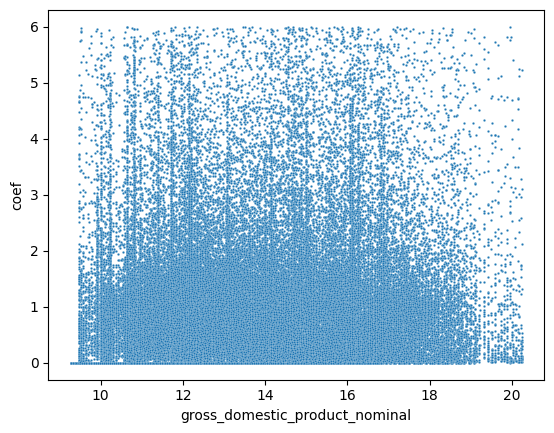

In [30]:
sns.scatterplot(data=df[df['coef']<6], y='coef', x=np.log(df['gross_domestic_product_nominal']), s=3)

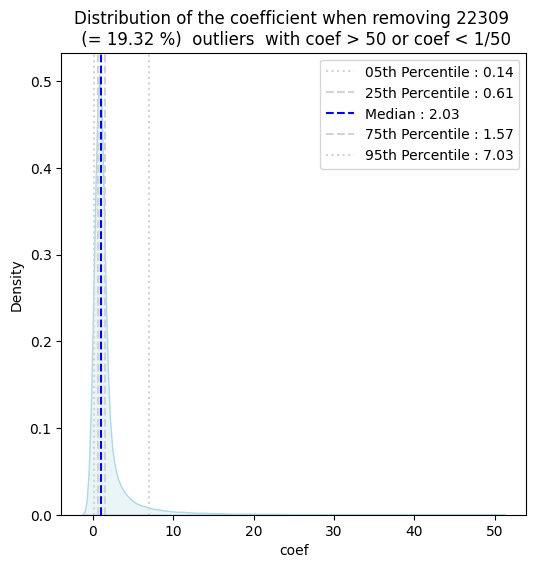

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))

original_shape = df.shape[0]
coef_threshold = 50
df_outliers = df[(df['coef'] > coef_threshold) | (df['coef'] < 1/coef_threshold)]
df_no_outliers = df[(df['coef'] < coef_threshold) & (df['coef'] > 1/coef_threshold)]
sns.kdeplot(data=df_no_outliers, x='coef', ax=ax, color='lightblue', fill=True)

plt.axvline(df_no_outliers['coef'].quantile(0.05), color='lightgrey', linestyle='dotted', label=f'05th Percentile : {df_no_outliers["coef"].quantile(0.05):.2f}')
plt.axvline(df_no_outliers['coef'].quantile(0.25), color='lightgrey', linestyle='--', label=f'25th Percentile : {df_no_outliers["coef"].quantile(0.25):.2f}')
plt.axvline(df_no_outliers['coef'].median(), color='blue', linestyle='--', label=f'Median : {df_no_outliers["coef"].mean():.2f}')
plt.axvline(df_no_outliers['coef'].quantile(0.75), color='lightgrey', linestyle='--', label=f'75th Percentile : {df_no_outliers["coef"].quantile(0.75):.2f}')
plt.axvline(df_no_outliers['coef'].quantile(0.95), color='lightgrey', linestyle='dotted', label=f'95th Percentile : {df_no_outliers["coef"].quantile(0.95):.2f}')



plt.title(f'Distribution of the coefficient when removing {df_outliers.shape[0]} \n (= {100*df_outliers.shape[0]/original_shape:.2f} %)  outliers  with coef > {coef_threshold} or coef < 1/{coef_threshold}')
plt.legend()
plt.show()

In [32]:
df_no_outliers.columns

Index(['Run', 'time', 'region', 'define_tot_eq_define_total_impact',
       'dice_tot_eq_dice_total_impact', 'dsk_tot_eq_dsk_total_impact',
       'fund_tot_eq_monetary_impact', 'fund_tot_eq_total_deaths',
       'fund_tot_eq_fund_total_impact', 'fund_tot_total_damage',
       'witness_tot_eq_witness_total_impact', 'temperature_change',
       'total_population', 'extra_extra_exponent',
       'extra_extra_normalisation_constant', 'coef', 'total_radiative_forcing',
       'gross_domestic_product_nominal', 'population_35_regions',
       'average_disposable_income_per_capita'],
      dtype='object')

In [33]:
variables_to_show = ['coef', 'temperature_change']

description_table = df_no_outliers[variables_to_show].describe()

latex_table = description_table.to_latex()

with open('../../../../Memoire/results/description_table.tex', 'w') as f:
    f.write(latex_table)

description_table

,coef,temperature_change
count,93191.000000,93191.000000
mean,2.028376,1.690354
std,4.253181,0.527822
min,0.020119,0.845000
25%,0.612536,1.271141
50%,0.997067,1.665065
75%,1.572891,2.030558
max,49.987579,3.332688


We need to have all the damages in the same column to process to the regression : 

In [53]:
df_melted = df_no_outliers.melt(id_vars=['time', 'region', 'extra_extra_exponent', 'extra_extra_normalisation_constant', 'total_radiative_forcing', 'coef', 'temperature_change', 'gross_domestic_product_nominal', 'average_disposable_income_per_capita', 'Run'], var_name='equation',  value_vars=damage_variables, value_name='damage')

# Removing outliers equations 
df_melted = df_melted[~df_melted['equation'].isin(['fund_tot_total_damage', 'fund_tot_eq_fund_total_impact', 'fund_tot_eq_monetary_impact', 'dsk_tot_eq_dsk_total_impact'])] 

# Drop infinite values
infinites = df_melted[(df_melted['damage'] == np.inf) | (df_melted['damage'] == -np.inf)]
df_melted.replace([np.inf, -np.inf], np.nan, inplace=True)

df_melted


,time,region,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,coef,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,Run,equation,damage
0,2005.0,BELGIUM,0.582127,47277.739995,1.714491,0.686361,0.845000,4.580816e+05,24767.399895,0,define_tot_eq_define_total_impact,6.443104e+02
1,2005.0,BULGARIA,0.582127,47277.739995,1.714491,0.247350,0.845000,4.934207e+04,4290.060541,0,define_tot_eq_define_total_impact,2.501084e+01
2,2005.0,CROATIA,0.582127,47277.739995,1.714491,0.344144,0.845000,4.937873e+04,7565.730576,0,define_tot_eq_define_total_impact,3.482407e+01
3,2005.0,CYPRUS,0.582127,47277.739995,1.714491,0.516904,0.845000,2.025158e+04,15217.411656,0,define_tot_eq_define_total_impact,2.145202e+01
4,2005.0,CZECH REPUBLIC,0.582127,47277.739995,1.714491,0.406000,0.845000,1.862598e+05,10050.031677,0,define_tot_eq_define_total_impact,1.549689e+02
...,...,...,...,...,...,...,...,...,...,...,...,...
652332,2070.0,INDIA,-0.385949,34549.432151,6.299000,3.825357,3.332688,9.795721e+06,1068.387514,49,witness_tot_eq_witness_total_impact,3.082382e+06
652333,2070.0,LATAM,-0.385949,34549.432151,6.299000,1.649069,3.332688,1.034895e+07,9453.049938,49,witness_tot_eq_witness_total_impact,1.403826e+06
652334,2070.0,RUSSIA,-0.385949,34549.432151,6.299000,0.493690,3.332688,5.092421e+07,215132.049308,49,witness_tot_eq_witness_total_impact,2.068030e+06
652335,2070.0,USMCA,-0.385949,34549.432151,6.299000,0.559478,3.332688,1.354051e+08,155574.525129,49,witness_tot_eq_witness_total_impact,6.231553e+06


<Axes: title={'center': 'Total radiative forcing distribution'}, ylabel='Density'>

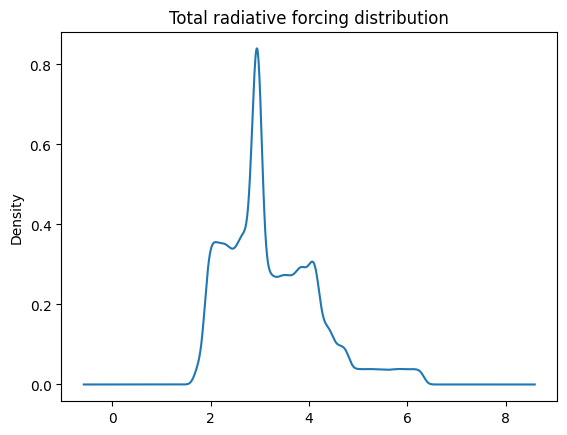

In [54]:
df_melted['total_radiative_forcing'].plot(kind='kde', title='Total radiative forcing distribution')

Here, we try to spot years that would be anormal.

In [55]:
df_2016 = df_melted[df_melted['time'] == 2015]
df_2016

,time,region,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,coef,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,Run,equation,damage
289,2015.0,BELGIUM,1.527778,43624.223854,2.177497,0.435557,1.075064,4.580816e+05,25320.161597,0,define_tot_eq_define_total_impact,678.608929
290,2015.0,BULGARIA,1.527778,43624.223854,2.177497,0.030909,1.075064,4.934207e+04,4481.498197,0,define_tot_eq_define_total_impact,5.187270
291,2015.0,CROATIA,1.527778,43624.223854,2.177497,0.071264,1.075064,4.937873e+04,7742.439308,0,define_tot_eq_define_total_impact,11.968489
292,2015.0,CYPRUS,1.527778,43624.223854,2.177497,0.199934,1.075064,2.025158e+04,15209.898854,0,define_tot_eq_define_total_impact,13.771362
293,2015.0,CZECH REPUBLIC,1.527778,43624.223854,2.177497,0.104783,1.075064,1.862598e+05,9964.687822,0,define_tot_eq_define_total_impact,66.380628
...,...,...,...,...,...,...,...,...,...,...,...,...
650809,2015.0,INDIA,-0.517334,28549.733144,2.409500,5.568037,1.154698,2.073712e+06,1033.161498,49,witness_tot_eq_witness_total_impact,90307.011671
650810,2015.0,LATAM,-0.517334,28549.733144,2.409500,2.215096,1.154698,3.228709e+06,6137.085294,49,witness_tot_eq_witness_total_impact,55936.134716
650811,2015.0,RUSSIA,-0.517334,28549.733144,2.409500,2.118355,1.154698,1.391604e+06,6690.368533,49,witness_tot_eq_witness_total_impact,23056.083772
650812,2015.0,USMCA,-0.517334,28549.733144,2.409500,0.947660,1.154698,2.091227e+07,31676.133804,49,witness_tot_eq_witness_total_impact,154997.542374


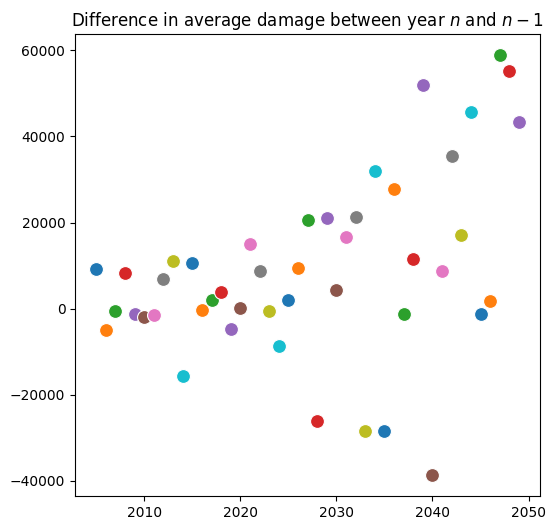

In [56]:
fig, ax = plt.subplots(figsize=(6, 6))

for year in range(2005, 2050):

    dif = df_melted.loc[df_melted['time'] == year+1, 'damage'].mean() - df_melted.loc[df_melted['time'] == year, 'damage'].mean()
    sns.scatterplot(x=[year], y=[dif], ax=ax, s=100, label=f'{year} - {year+1}', legend=False)


plt.title('Difference in average damage between year $n$ and $n-1$')
plt.show()

Since there is obviously something happening in 2015 and we do not understand why, we will remove the year 2015. 

In [57]:
#df_melted = df_melted[~df_melted['time'].isin([2015, 2043,  2048])] It disappeared in later runs

In [58]:
df_melted['coef'].describe()

count    279573.000000
mean          2.028376
std           4.253166
min           0.020119
25%           0.612507
50%           0.997067
75%           1.572945
max          49.987579
Name: coef, dtype: float64

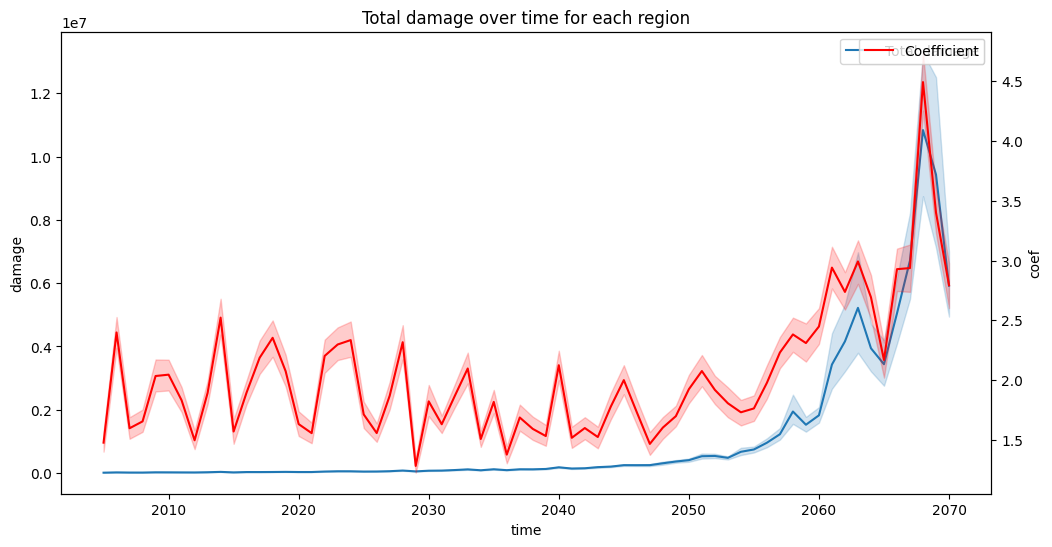

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))


#df_melted_grouped_region = df_melted.groupby(['time', 'REGIONS 35 I']).mean().reset_index()
sns.lineplot(data=df_melted, x='time', y='damage', legend=True, estimator='mean', ax=ax, label='Total damage')
ax2 = ax.twinx()
sns.lineplot(data=df_melted, x='time', y='coef', legend=True, estimator='mean', ax=ax2, color='red', label='Coefficient')

plt.title('Total damage over time for each region')
plt.legend()
#ax.set_yscale('log')

plt.show()  

### Checking where and when the damages are the higher

This step serves to check irregularities in the experimental setup. 

In [60]:
# Drop infinite values
infinites = df_melted[(df_melted['damage'] == np.inf) | (df_melted['damage'] == -np.inf)]
df_melted.replace([np.inf, -np.inf], np.nan, inplace=True)
infinites.size

0

### Creating the total_damage dataset

We want to compute the global level of damage, since this is how optimal level of emissions are calculated. 

In [61]:
df_melted.columns

Index(['time', 'region', 'extra_extra_exponent',
       'extra_extra_normalisation_constant', 'total_radiative_forcing', 'coef',
       'temperature_change', 'gross_domestic_product_nominal',
       'average_disposable_income_per_capita', 'Run', 'equation', 'damage'],
      dtype='object')

In [62]:
df_melted

,time,region,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,coef,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,Run,equation,damage
0,2005.0,BELGIUM,0.582127,47277.739995,1.714491,0.686361,0.845000,4.580816e+05,24767.399895,0,define_tot_eq_define_total_impact,6.443104e+02
1,2005.0,BULGARIA,0.582127,47277.739995,1.714491,0.247350,0.845000,4.934207e+04,4290.060541,0,define_tot_eq_define_total_impact,2.501084e+01
2,2005.0,CROATIA,0.582127,47277.739995,1.714491,0.344144,0.845000,4.937873e+04,7565.730576,0,define_tot_eq_define_total_impact,3.482407e+01
3,2005.0,CYPRUS,0.582127,47277.739995,1.714491,0.516904,0.845000,2.025158e+04,15217.411656,0,define_tot_eq_define_total_impact,2.145202e+01
4,2005.0,CZECH REPUBLIC,0.582127,47277.739995,1.714491,0.406000,0.845000,1.862598e+05,10050.031677,0,define_tot_eq_define_total_impact,1.549689e+02
...,...,...,...,...,...,...,...,...,...,...,...,...
652332,2070.0,INDIA,-0.385949,34549.432151,6.299000,3.825357,3.332688,9.795721e+06,1068.387514,49,witness_tot_eq_witness_total_impact,3.082382e+06
652333,2070.0,LATAM,-0.385949,34549.432151,6.299000,1.649069,3.332688,1.034895e+07,9453.049938,49,witness_tot_eq_witness_total_impact,1.403826e+06
652334,2070.0,RUSSIA,-0.385949,34549.432151,6.299000,0.493690,3.332688,5.092421e+07,215132.049308,49,witness_tot_eq_witness_total_impact,2.068030e+06
652335,2070.0,USMCA,-0.385949,34549.432151,6.299000,0.559478,3.332688,1.354051e+08,155574.525129,49,witness_tot_eq_witness_total_impact,6.231553e+06


In [63]:
# Aggregating the data to have one row per time and equation
damage_aggregated = df_melted.groupby(['time', 'equation', 'Run']).agg({'damage': 'sum', 
                                                                 'gross_domestic_product_nominal': 'sum',
                                                                 'total_radiative_forcing': 'first', 
                                                                 'temperature_change': 'first', 
                                                                 'extra_extra_exponent' : 'first', 
                                                                 'extra_extra_normalisation_constant' : 'first'
                                                                 }).reset_index()

# Creating a dummy variable for the equation 
# Creating dummy variables for the equation
equation_dummies = pd.get_dummies(damage_aggregated['equation'], prefix='equation', drop_first=True)

# Concatenating the dummy variables back to the original dataframe
damage_aggregated = pd.concat([damage_aggregated, equation_dummies], axis=1)

# Renaming columns to simplify the analysis
damage_aggregated = damage_aggregated.rename(columns={'extra_extra_exponent': 'exponent', 'extra_extra_normalisation_constant': 'constant'})

damage_aggregated

,time,equation,Run,damage,gross_domestic_product_nominal,total_radiative_forcing,temperature_change,exponent,constant,equation_dice_tot_eq_dice_total_impact,equation_witness_tot_eq_witness_total_impact
0,2005.0,define_tot_eq_define_total_impact,0,7.450947e+04,7.153753e+07,1.714491,0.845000,0.582127,47277.739995,False,False
1,2005.0,define_tot_eq_define_total_impact,1,9.040747e+05,6.011960e+07,1.901000,0.845000,-2.121818,25090.060841,False,False
2,2005.0,define_tot_eq_define_total_impact,2,8.031957e+04,7.153753e+07,1.905000,0.845000,1.006430,30769.251023,False,False
3,2005.0,define_tot_eq_define_total_impact,3,9.675407e+04,7.153753e+07,1.904000,0.845000,0.835711,26448.878637,False,False
4,2005.0,define_tot_eq_define_total_impact,4,1.480256e+05,7.153753e+07,1.906000,0.845000,-0.118945,12024.511041,False,False
...,...,...,...,...,...,...,...,...,...,...,...
9895,2070.0,witness_tot_eq_witness_total_impact,45,6.717711e+07,1.177401e+09,4.784617,2.603701,-1.332942,48087.730499,False,True
9896,2070.0,witness_tot_eq_witness_total_impact,46,2.825308e+07,1.513754e+09,4.443000,2.429880,-0.878792,33078.247973,False,True
9897,2070.0,witness_tot_eq_witness_total_impact,47,6.564956e+07,1.498663e+09,4.188000,2.413231,0.090598,40230.958488,False,True
9898,2070.0,witness_tot_eq_witness_total_impact,48,2.952544e+07,1.159378e+09,2.854000,1.799231,-1.290950,49412.592003,False,True


<Axes: xlabel='time', ylabel='damage'>

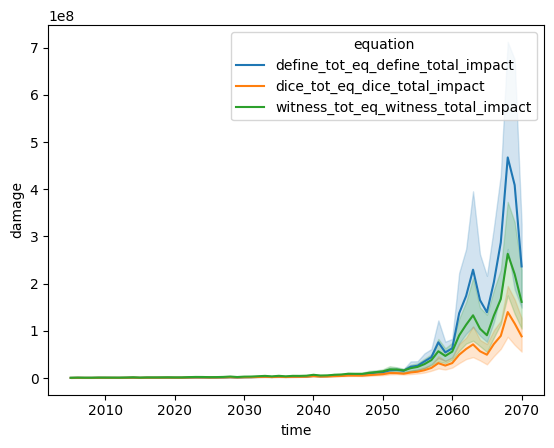

In [64]:
sns.lineplot(data=damage_aggregated, x='time', y='damage', hue='equation', estimator='mean')

In [65]:
damage_aggregated['log_exponent'] = np.log(damage_aggregated['exponent'])
damage_aggregated['log_damage'] = np.log(damage_aggregated['damage'])
damage_aggregated['log_constant'] = np.log(damage_aggregated['constant'])

c:\Users\gabriel.genelot\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [66]:
import statsmodels.api as sm

# Préparer les variables indépendantes (X) et dépendante (y)
X = damage_aggregated[['temperature_change', 
                       'exponent', 
                       'constant']]

y = damage_aggregated['damage']

# Ajouter une constante (intercept) à X
X = sm.add_constant(X)

# Ajuster le modèle de régression OLS
model = sm.OLS(y, X).fit()

# Résumé des résultats
model.summary()
#print(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 damage   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     583.3
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        10:57:01   Log-Likelihood:            -1.9933e+05
No. Observations:                9900   AIC:                         3.987e+05
Df Residuals:                    9896   BIC:                         3.987e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.214e+08   5.69e+06    -21.330      0.000   -1.33e+08    -1.1e+08
temperature_change  9.583e+07   2.54e+06     37.745      0.000    9.09e+07    1.01e+08
exponent            2.402e+07   1.33e+06     18.085      0.000    2.14e+07    2.66e+07
constant            -372.5982    117.642     -3.167      0.002    -603.201    -141.995
==============================================================================
Omnibus:                    19672.151   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         70437765.429
Skew:                          15.970   Prob(JB):                         0.00
Kurtosis:                     414.993   Cond. No.                     1.44e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Exporting the datasets

In [67]:
# Save the dataframe to a csv file to access it from the other notebook
df_melted.to_csv('damage_country.csv', index=False)
damage_aggregated.to_csv('damage_aggregated.csv', index=False)